<a href="https://colab.research.google.com/github/maximdorogov/sar2optical/blob/main/sar2optical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

import cv2
import os

### Reference paper

https://arxiv.org/pdf/1611.07004.pdf

### Building blocks

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=4,
                  stride=stride, 
                  padding=1, 
                  bias=False, 
                  padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),)

    def forward(self, x):
        return self.conv(x)

### The Patch GAN Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2)
        )

        layers = [
            CNNBlock(in_channels=64, out_channels=128, stride=2),
            CNNBlock(in_channels=128, out_channels=256, stride=2),
            CNNBlock(in_channels=256, out_channels=512, stride=1),
            nn.Conv2d(
               in_channels=512,
               out_channels=1,
               kernel_size=4,
               stride=1,
               padding=1,
               padding_mode="reflect"
            ),
            nn.Sigmoid()
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
summary(PatchDiscriminator(), [(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
          CNNBlock-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
         CNNBlock-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-12          [-1, 512, 31, 31]           1,024
        LeakyReLU-13          [-1, 512, 31, 31]               0
         CNNBlock-14          [-1, 512,

### U-Net Generator

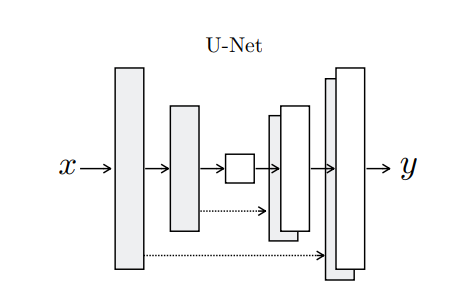

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(UnetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = UnetBlock(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = UnetBlock(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = UnetBlock(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = UnetBlock(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = UnetBlock(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = UnetBlock(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = UnetBlock(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = UnetBlock(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = UnetBlock(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = UnetBlock(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = UnetBlock(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = UnetBlock(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = UnetBlock(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
summary(Generator(), [(3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
         UnetBlock-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
        UnetBlock-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
        LeakyReLU-13          [-1, 512, 16, 16]               0
        UnetBlock-14          [-1, 512,

### Dataset preparation

In [ ]:
# sentinel 1 (SAR) images folder
sar_data_path = '/content/drive/MyDrive/GoogleCollab/DeepLearning_UNS/TP-SAR2Optical/dataset/spring/s1_90'
# sentinel 2 (optical) images folder name
optic_data_path = '/content/drive/MyDrive/GoogleCollab/DeepLearning_UNS/TP-SAR2Optical/dataset/spring/s2_90'

In [ ]:
class Pix2PixDataset(Dataset):
    def __init__(self, input_root_dir, target_root_dir, transform=None):
        super().__init__()
        self.input_root_dir = input_root_dir
        self.target_root_dir = target_root_dir
        self.input_list = sorted(os.listdir(self.input_root_dir))
        self.target_list = sorted(os.listdir(self.target_root_dir))
        self.transform = transform

        assert len(self.input_list) == len(self.target_list), \
            "unequal quantity between input and target files"

    def __getitem__(self, index):

        input_name = self.input_list[index]
        target_name = self.target_list[index]

        input_path = os.path.join(self.input_root_dir, input_name)
        target_path = os.path.join(self.target_root_dir, target_name)

        input_img = np.array(Image.open(input_path))
        target_img = np.array(Image.open(target_path))
        
        # stack the input to have 3 channels if is grayscale
        if len(input_img.shape) is 2:
            input_img = np.stack((input_img,) * 3, axis=-1)

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

    def __len__(self):
        return len(self.input_list)

Visualizing some input and target samples from the dataset

(-0.5, 255.5, 255.5, -0.5)

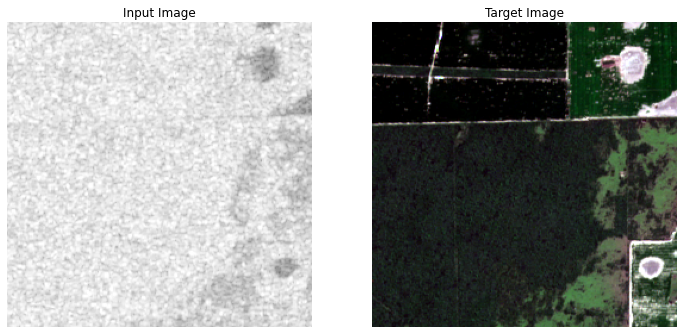

In [ ]:
data = Pix2PixDataset(sar_data_path, optic_data_path)

s1, s2 = data[796]

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(s1, cmap = 'gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(s2)
plt.title('Target Image')
plt.axis('off')

### Dataset preparation

In [ ]:
# normalize data between -1 y 1
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = Pix2PixDataset(sar_data_path, optic_data_path, transform=img_transform)

TEST_LEN = int(len(data)*0.1)
TRAIN_LEN = len(data) - TEST_LEN
BATCH_SIZE = 16 #64

train_data, test_data = random_split(data, [TRAIN_LEN, TEST_LEN])
print(f'train samples: {len(train_data)}, test samples: {len(test_data)}')

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

train samples: 720, test samples: 80


### Training

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 100
L_RATE = 2e-4
LAMBDA = 100

In [ ]:
discriminator = PatchDiscriminator(in_channels=3).to(DEVICE)
generator = Generator(in_channels=3).to(DEVICE)

opt_disc = optim.Adam(discriminator.parameters(), lr=L_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(generator.parameters(), lr=L_RATE, betas=(0.5, 0.999))

BCE_loss = nn.BCELoss()
L1_loss = nn.L1Loss()

In [ ]:
# average losses per batch used to plot
disc_loss_avg, gen_loss_avg = [], []

discriminator.train()
generator.train()

print('Training ...')
for epoch in range(NUM_EPOCHS):

    num_batches = 0
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)

    for input, target in train_dataloader:
        input, target = input.to(DEVICE), target.to(DEVICE)

        # Train Discriminator w/ fake target
        opt_disc.zero_grad()
        fake_target = generator(input)
        output_label = discriminator(input, fake_target)

        # ground truth labels (patches) real and fake
        real_disc_target = Variable(torch.ones(output_label.size()).to(DEVICE))
        fake_disc_target = Variable(torch.zeros(output_label.size()).to(DEVICE))

        # compute fake_loss
        D_fake_loss = BCE_loss(output_label, fake_disc_target)

        # Train Discriminator w/ real target
        real_label = discriminator(input, target)
        # compute real_loss
        D_real_loss = BCE_loss(real_label, real_disc_target)
        # total discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2

        D_total_loss.backward()
        opt_disc.step()

        # Train generator with real labels
        opt_gen.zero_grad()
        fake_target = generator(input)
        D_fake_output = discriminator(input, fake_target)
        d_fake_target = Variable(torch.ones(D_fake_output.size()).to(DEVICE))
        Disc_fake_loss = BCE_loss(D_fake_output, d_fake_target)
        G_loss = L1_loss(fake_target, target) * LAMBDA
        gen_total_loss = G_loss + Disc_fake_loss

        gen_total_loss.backward()
        opt_gen.step()

        disc_loss_avg[-1] += D_total_loss.item()
        gen_loss_avg[-1] += gen_total_loss.item()
        num_batches += 1
    
    disc_loss_avg[-1] /= num_batches
    gen_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] generator avg loss: %.2f discriminator avg loss: %.2f' % (epoch+1, NUM_EPOCHS, gen_loss_avg[-1], disc_loss_avg[-1]))

### Save trained model

In [ ]:
PATH = '/content/drive/MyDrive/GoogleCollab/DeepLearning_UNS/TP-SAR2Optical/'
GENERATOR_NAME = 'generator_100epochs.pt'
torch.save(generator.state_dict(), PATH + GENERATOR_NAME)
DISC_NAME = 'discriminator_100epochs.pt'
torch.save(discriminator.state_dict(), PATH + DISC_NAME)

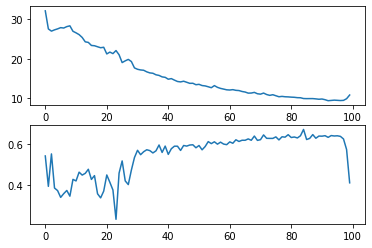

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(gen_loss_avg)
plt.subplot(2,1,2)
plt.plot(disc_loss_avg)

### Generator validation

In [ ]:
PATH = '/content/drive/MyDrive/GoogleCollab/DeepLearning_UNS/TP-SAR2Optical/'
GENERATOR_NAME = 'generator_100epochs.pt'
generator = Generator(in_channels=3).to(DEVICE)
generator.load_state_dict(torch.load(PATH + GENERATOR_NAME, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
generator.eval()

s1, s2 = test_data[67]

with torch.no_grad():
    s2_hat = generator(s1.unsqueeze(dim=0).to(DEVICE))

(-0.5, 255.5, 255.5, -0.5)

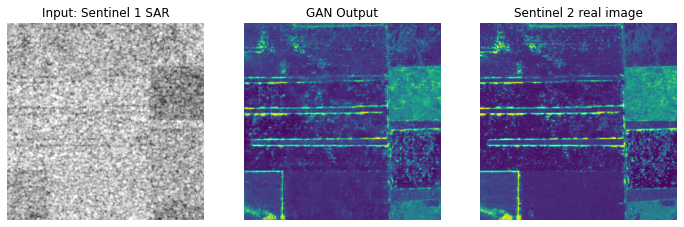

In [ ]:
plt.figure(figsize=(12,12))

s2_hat_img = s2_hat.to(DEVICE).squeeze().permute((2, 1, 0))
s2_img = s2.to(DEVICE).squeeze().permute((2, 1, 0))

plt.subplot(1,3,2)
plt.imshow(s2_hat.to('cpu').squeeze()[2,:,:])
plt.title('GAN Output')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(s2.to('cpu').squeeze()[2,:,:])
plt.title('Sentinel 2 real image')
plt.axis('off')
plt.subplot(1,3,1)
plt.imshow(s1.to('cpu').squeeze()[1,:,:], cmap='gray')
plt.title('Input: Sentinel 1 SAR')
plt.axis('off')

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x.permute(0, 2, 3, 1)

In [ ]:
input, target = next(iter(test_dataloader))

generator.eval()
with torch.no_grad():
    sen2_hat = generator(input.to(DEVICE))

In [ ]:
output2plot = to_img(sen2_hat)
target2plot = to_img(target)
input2plot = to_img(input)

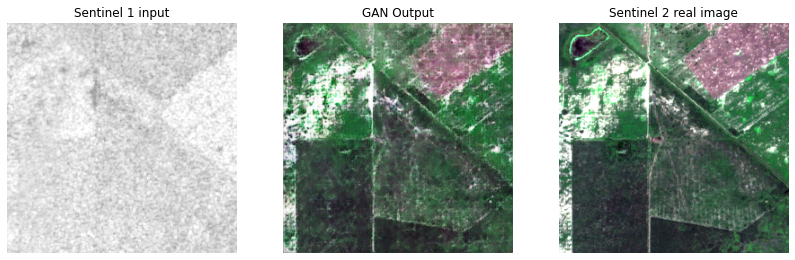

In [ ]:
# modificar el valor de i entre 0 y 15 para visualizar los resultados
i=2

plt.figure(figsize=(14,14))  
plt.subplot(1, 3, 1)
plt.imshow(input2plot[i])
plt.title('Sentinel 1 input')
plt.axis('off')
j+=1
plt.subplot(1, 3, 2)
plt.imshow(output2plot[i])
plt.title('GAN Output')
plt.axis('off')
j+=1
plt.subplot(1, 3, 3) 
plt.imshow(target2plot[i])
plt.title('Sentinel 2 real image')
plt.axis('off')
j+=1
    